# DLITE vs. Cross Entropy for Tinyshakespeare

Lixiao Yang\
8/31/2023

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    # Define the Cross Entropy loss function here
    ce_loss_func = nn.CrossEntropyLoss()

    dlite_out = {}
    ce_out = {}
    model.eval()
    for split in ['train', 'val']:
        dlite_losses = torch.zeros(eval_iters)
        ce_losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, _ = model(X, Y)
            dlite_losses[k] = dlite_loss(logits, Y.view(-1)).item()
            ce_losses[k] = ce_loss_func(logits.view(-1, vocab_size), Y.view(-1)).item()
        dlite_out[split] = dlite_losses.mean()
        ce_out[split] = ce_losses.mean()
    model.train()
    return dlite_out, ce_out


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# DLITE Loss function
class DLITELoss(nn.Module):
    def __init__(self):
        super(DLITELoss, self).__init__()

    def forward(self, logits, targets, epsilon=1e-10):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=-1)
        
        # One-hot encode the targets to get true probabilities
        true_probs = F.one_hot(targets, num_classes=probs.size(-1)).float()
        
        # Define the g function
        g_values = torch.abs(probs * (1 - torch.log(probs + epsilon)) - true_probs * (1 - torch.log(true_probs + epsilon)))

        # Define the delta_h function
        delta_h_values = torch.abs(probs**2 * (1 - 2 * torch.log(probs + epsilon)) - true_probs**2 * (1 - 2 * torch.log(true_probs + epsilon))) / (2 * (probs + true_probs))

        # Compute DLITE loss for each class
        dl_values = g_values - delta_h_values
        
        # Sum over all classes and average over batch size
        loss = dl_values.sum(dim=-1).mean()
        
        return loss
    
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.loss_func = DLITELoss()  # Initialize the DLITE loss function

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = self.loss_func(logits, targets)  # Use DLITE loss here

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



## Baseline training using DLITE

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()

# Lists to store the loss values
train_losses_dlite = []
val_losses_dlite = []
ce_train_losses_dlite = []
ce_val_losses_dlite = []

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses = estimate_loss()
        print(f"step {iter}: DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}, CE train loss: {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}\n")

        # Append the losses for this iteration
        train_losses_dlite.append(dlite_losses['train'])
        val_losses_dlite.append(dlite_losses['val'])
        ce_train_losses_dlite.append(ce_losses['train'])
        ce_val_losses_dlite.append(ce_losses['val'])


    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)

    # Compute the DLITE loss using the flattened logits and targets
    loss = dlite_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


0.209729 M parameters
step 0: DLITE train loss 0.9281, DLITE val loss 0.9275, CE train loss: 4.4116, CE val loss 4.4022

step 100: DLITE train loss 0.6724, DLITE val loss 0.6736, CE train loss: 3.3286, CE val loss 3.4020

step 200: DLITE train loss 0.6473, DLITE val loss 0.6496, CE train loss: 3.3343, CE val loss 3.4157

step 300: DLITE train loss 0.6312, DLITE val loss 0.6367, CE train loss: 3.3303, CE val loss 3.4446

step 400: DLITE train loss 0.6191, DLITE val loss 0.6233, CE train loss: 3.2554, CE val loss 3.3493

step 500: DLITE train loss 0.6066, DLITE val loss 0.6124, CE train loss: 3.2216, CE val loss 3.3095

step 600: DLITE train loss 0.5897, DLITE val loss 0.5908, CE train loss: 3.0713, CE val loss 3.0989

step 700: DLITE train loss 0.5813, DLITE val loss 0.5856, CE train loss: 3.0849, CE val loss 3.1262

step 800: DLITE train loss 0.5680, DLITE val loss 0.5752, CE train loss: 3.0209, CE val loss 3.0716

step 900: DLITE train loss 0.5614, DLITE val loss 0.5680, CE train loss

## Baseline training using Cross Entropy

In [3]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

torch.manual_seed(1337)


model = BigramLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
dlite_loss = DLITELoss()
ce_loss = nn.CrossEntropyLoss()  # Cross-Entropy loss

# Lists to store the loss values
train_losses_ce = []
val_losses_ce = []
ce_train_losses_ce = []  # Cross-Entropy train losses
ce_val_losses_ce = []    # Cross-Entropy validation losses

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        dlite_losses, ce_losses = estimate_loss()
        print(f"step {iter}:CE train loss: {ce_losses['train']:.4f}, CE val loss {ce_losses['val']:.4f}, DLITE train loss {dlite_losses['train']:.4f}, DLITE val loss {dlite_losses['val']:.4f}\n")

        # Append the losses for this iteration
        train_losses_ce.append(dlite_losses['train'])
        val_losses_ce.append(dlite_losses['val'])
        ce_train_losses_ce.append(ce_losses['train'])
        ce_val_losses_ce.append(ce_losses['val'])

    # Sample a batch of data
    xb, yb = get_batch('train')

    # Evaluate the logits
    logits, _ = model(xb, yb)

    # Flatten the logits and target tensor
    logits_flat = logits.view(-1, logits.shape[-1])
    targets_flat = yb.view(-1)

    # Compute the Cross-Entropy loss using the flattened logits and targets
    loss = ce_loss(logits_flat, targets_flat)

    # Backpropagation and optimization step
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()



0.209729 M parameters
step 0:CE train loss: 4.4116, CE val loss 4.4022, DLITE train loss 0.9281, DLITE val loss 0.9275

step 100:CE train loss: 2.6568, CE val loss 2.6670, DLITE train loss 0.6977, DLITE val loss 0.6981

step 200:CE train loss: 2.5091, CE val loss 2.5058, DLITE train loss 0.6712, DLITE val loss 0.6701

step 300:CE train loss: 2.4198, CE val loss 2.4338, DLITE train loss 0.6490, DLITE val loss 0.6506

step 400:CE train loss: 2.3499, CE val loss 2.3562, DLITE train loss 0.6344, DLITE val loss 0.6347

step 500:CE train loss: 2.2964, CE val loss 2.3128, DLITE train loss 0.6187, DLITE val loss 0.6209

step 600:CE train loss: 2.2407, CE val loss 2.2499, DLITE train loss 0.6099, DLITE val loss 0.6096

step 700:CE train loss: 2.2064, CE val loss 2.2200, DLITE train loss 0.5984, DLITE val loss 0.6000

step 800:CE train loss: 2.1640, CE val loss 2.1873, DLITE train loss 0.5911, DLITE val loss 0.5942

step 900:CE train loss: 2.1252, CE val loss 2.1515, DLITE train loss 0.5829, DLI

In [13]:
# Initialize empty lists to store the loss values
train_losses_dlite = []
val_losses_dlite = []
ce_train_losses_dlite = []
ce_val_losses_dlite = []

# Sample output string representing evaluation results
evaluation_results_str = """
step 0: DLITE train loss 0.9281, DLITE val loss 0.9275, CE train loss: 4.4116, CE val loss 4.4022
step 100: DLITE train loss 0.6724, DLITE val loss 0.6736, CE train loss: 3.3286, CE val loss 3.4020
step 200: DLITE train loss 0.6473, DLITE val loss 0.6496, CE train loss: 3.3343, CE val loss 3.4157
step 300: DLITE train loss 0.6312, DLITE val loss 0.6367, CE train loss: 3.3303, CE val loss 3.4446
step 400: DLITE train loss 0.6191, DLITE val loss 0.6233, CE train loss: 3.2554, CE val loss 3.3493
step 500: DLITE train loss 0.6066, DLITE val loss 0.6124, CE train loss: 3.2216, CE val loss 3.3095
step 600: DLITE train loss 0.5897, DLITE val loss 0.5908, CE train loss: 3.0713, CE val loss 3.0989
step 700: DLITE train loss 0.5813, DLITE val loss 0.5856, CE train loss: 3.0849, CE val loss 3.1262
step 800: DLITE train loss 0.5680, DLITE val loss 0.5752, CE train loss: 3.0209, CE val loss 3.0716
step 900: DLITE train loss 0.5614, DLITE val loss 0.5680, CE train loss: 2.9872, CE val loss 3.0298
step 1000: DLITE train loss 0.5566, DLITE val loss 0.5635, CE train loss: 3.0932, CE val loss 3.1294
step 1100: DLITE train loss 0.5532, DLITE val loss 0.5627, CE train loss: 3.1069, CE val loss 3.1641
step 1200: DLITE train loss 0.5448, DLITE val loss 0.5525, CE train loss: 3.0217, CE val loss 3.0474
step 1300: DLITE train loss 0.5431, DLITE val loss 0.5509, CE train loss: 3.0046, CE val loss 3.0375
step 1400: DLITE train loss 0.5344, DLITE val loss 0.5446, CE train loss: 2.9663, CE val loss 3.0129
step 1500: DLITE train loss 0.5332, DLITE val loss 0.5447, CE train loss: 2.9673, CE val loss 3.0299
step 1600: DLITE train loss 0.5271, DLITE val loss 0.5447, CE train loss: 2.9694, CE val loss 3.0988
step 1700: DLITE train loss 0.5262, DLITE val loss 0.5401, CE train loss: 3.0137, CE val loss 3.0903
step 1800: DLITE train loss 0.5187, DLITE val loss 0.5381, CE train loss: 2.9626, CE val loss 3.0824
step 1900: DLITE train loss 0.5209, DLITE val loss 0.5344, CE train loss: 3.0012, CE val loss 3.0771
step 2000: DLITE train loss 0.5170, DLITE val loss 0.5380, CE train loss: 3.0137, CE val loss 3.1436
step 2100: DLITE train loss 0.5118, DLITE val loss 0.5322, CE train loss: 2.9773, CE val loss 3.1043
step 2200: DLITE train loss 0.5086, DLITE val loss 0.5261, CE train loss: 2.9430, CE val loss 3.0444
step 2300: DLITE train loss 0.5062, DLITE val loss 0.5261, CE train loss: 2.9045, CE val loss 3.0351
step 2400: DLITE train loss 0.5040, DLITE val loss 0.5228, CE train loss: 2.9504, CE val loss 3.0600
step 2500: DLITE train loss 0.4986, DLITE val loss 0.5222, CE train loss: 2.9177, CE val loss 3.0495
step 2600: DLITE train loss 0.5026, DLITE val loss 0.5231, CE train loss: 2.9697, CE val loss 3.0701
step 2700: DLITE train loss 0.4987, DLITE val loss 0.5194, CE train loss: 3.0023, CE val loss 3.1136
step 2800: DLITE train loss 0.4976, DLITE val loss 0.5180, CE train loss: 2.8894, CE val loss 3.0086
step 2900: DLITE train loss 0.4941, DLITE val loss 0.5169, CE train loss: 2.8783, CE val loss 3.0223
step 3000: DLITE train loss 0.4938, DLITE val loss 0.5150, CE train loss: 2.9540, CE val loss 3.0846
step 3100: DLITE train loss 0.4877, DLITE val loss 0.5133, CE train loss: 2.8746, CE val loss 3.0534
step 3200: DLITE train loss 0.4840, DLITE val loss 0.5120, CE train loss: 2.8586, CE val loss 3.0347
step 3300: DLITE train loss 0.4862, DLITE val loss 0.5105, CE train loss: 2.9568, CE val loss 3.0735
step 3400: DLITE train loss 0.4851, DLITE val loss 0.5073, CE train loss: 2.8963, CE val loss 3.0489
step 3500: DLITE train loss 0.4820, DLITE val loss 0.5088, CE train loss: 2.9108, CE val loss 3.0744
step 3600: DLITE train loss 0.4791, DLITE val loss 0.5082, CE train loss: 2.9077, CE val loss 3.0899
step 3700: DLITE train loss 0.4805, DLITE val loss 0.5066, CE train loss: 2.9154, CE val loss 3.0688
step 3800: DLITE train loss 0.4790, DLITE val loss 0.5075, CE train loss: 2.8763, CE val loss 3.0598
step 3900: DLITE train loss 0.4751, DLITE val loss 0.5012, CE train loss: 2.8677, CE val loss 3.0319
step 4000: DLITE train loss 0.4749, DLITE val loss 0.4995, CE train loss: 2.8587, CE val loss 3.0094
step 4100: DLITE train loss 0.4756, DLITE val loss 0.5015, CE train loss: 2.8847, CE val loss 3.0455
step 4200: DLITE train loss 0.4731, DLITE val loss 0.5017, CE train loss: 2.8562, CE val loss 3.0305
step 4300: DLITE train loss 0.4742, DLITE val loss 0.5009, CE train loss: 2.9310, CE val loss 3.0915
step 4400: DLITE train loss 0.4730, DLITE val loss 0.4970, CE train loss: 2.8895, CE val loss 3.0391
step 4500: DLITE train loss 0.4705, DLITE val loss 0.4958, CE train loss: 2.8066, CE val loss 2.9600
step 4600: DLITE train loss 0.4705, DLITE val loss 0.4965, CE train loss: 2.8394, CE val loss 2.9922
step 4700: DLITE train loss 0.4684, DLITE val loss 0.4952, CE train loss: 2.8956, CE val loss 3.0613
step 4800: DLITE train loss 0.4646, DLITE val loss 0.4955, CE train loss: 2.8529, CE val loss 3.0704
step 4900: DLITE train loss 0.4664, DLITE val loss 0.4925, CE train loss: 2.8666, CE val loss 3.0474
step 4999: DLITE train loss 0.4652, DLITE val loss 0.4906, CE train loss: 2.8259, CE val loss 2.9784
"""

# Split the string into lines and parse each line
for line in evaluation_results_str.strip().split('\n'):
    parts = line.split(", ")
    train_losses_dlite.append(float(parts[0].split(" ")[-1]))
    val_losses_dlite.append(float(parts[1].split(" ")[-1]))
    ce_train_losses_dlite.append(float(parts[2].split(" ")[-1]))
    ce_val_losses_dlite.append(float(parts[3].split(" ")[-1]))

train_losses_dlite, val_losses_dlite, ce_train_losses_dlite, ce_val_losses_dlite


([0.9281,
  0.6724,
  0.6473,
  0.6312,
  0.6191,
  0.6066,
  0.5897,
  0.5813,
  0.568,
  0.5614,
  0.5566,
  0.5532,
  0.5448,
  0.5431,
  0.5344,
  0.5332,
  0.5271,
  0.5262,
  0.5187,
  0.5209,
  0.517,
  0.5118,
  0.5086,
  0.5062,
  0.504,
  0.4986,
  0.5026,
  0.4987,
  0.4976,
  0.4941,
  0.4938,
  0.4877,
  0.484,
  0.4862,
  0.4851,
  0.482,
  0.4791,
  0.4805,
  0.479,
  0.4751,
  0.4749,
  0.4756,
  0.4731,
  0.4742,
  0.473,
  0.4705,
  0.4705,
  0.4684,
  0.4646,
  0.4664,
  0.4652],
 [0.9275,
  0.6736,
  0.6496,
  0.6367,
  0.6233,
  0.6124,
  0.5908,
  0.5856,
  0.5752,
  0.568,
  0.5635,
  0.5627,
  0.5525,
  0.5509,
  0.5446,
  0.5447,
  0.5447,
  0.5401,
  0.5381,
  0.5344,
  0.538,
  0.5322,
  0.5261,
  0.5261,
  0.5228,
  0.5222,
  0.5231,
  0.5194,
  0.518,
  0.5169,
  0.515,
  0.5133,
  0.512,
  0.5105,
  0.5073,
  0.5088,
  0.5082,
  0.5066,
  0.5075,
  0.5012,
  0.4995,
  0.5015,
  0.5017,
  0.5009,
  0.497,
  0.4958,
  0.4965,
  0.4952,
  0.4955,
  0.4925,
  

In [14]:
# Initialize empty lists to store the loss values
ce_train_losses_ce = []
ce_val_losses_ce = []
train_losses_ce = []
val_losses_ce = []

# Sample output string representing evaluation results
evaluation_results_str = """
step 0:CE train loss: 4.4116, CE val loss 4.4022, DLITE train loss 0.9281, DLITE val loss 0.9275
step 100:CE train loss: 2.6568, CE val loss 2.6670, DLITE train loss 0.6977, DLITE val loss 0.6981
step 200:CE train loss: 2.5091, CE val loss 2.5058, DLITE train loss 0.6712, DLITE val loss 0.6701
step 300:CE train loss: 2.4198, CE val loss 2.4338, DLITE train loss 0.6490, DLITE val loss 0.6506
step 400:CE train loss: 2.3499, CE val loss 2.3562, DLITE train loss 0.6344, DLITE val loss 0.6347
step 500:CE train loss: 2.2964, CE val loss 2.3128, DLITE train loss 0.6187, DLITE val loss 0.6209
step 600:CE train loss: 2.2407, CE val loss 2.2499, DLITE train loss 0.6099, DLITE val loss 0.6096
step 700:CE train loss: 2.2064, CE val loss 2.2200, DLITE train loss 0.5984, DLITE val loss 0.6000
step 800:CE train loss: 2.1640, CE val loss 2.1873, DLITE train loss 0.5911, DLITE val loss 0.5942
step 900:CE train loss: 2.1252, CE val loss 2.1515, DLITE train loss 0.5829, DLITE val loss 0.5867
step 1000:CE train loss: 2.1028, CE val loss 2.1295, DLITE train loss 0.5738, DLITE val loss 0.5773
step 1100:CE train loss: 2.0711, CE val loss 2.1194, DLITE train loss 0.5705, DLITE val loss 0.5777
step 1200:CE train loss: 2.0388, CE val loss 2.0797, DLITE train loss 0.5616, DLITE val loss 0.5674
step 1300:CE train loss: 2.0258, CE val loss 2.0647, DLITE train loss 0.5547, DLITE val loss 0.5608
step 1400:CE train loss: 1.9934, CE val loss 2.0378, DLITE train loss 0.5485, DLITE val loss 0.5557
step 1500:CE train loss: 1.9705, CE val loss 2.0305, DLITE train loss 0.5453, DLITE val loss 0.5554
step 1600:CE train loss: 1.9643, CE val loss 2.0479, DLITE train loss 0.5421, DLITE val loss 0.5557
step 1700:CE train loss: 1.9411, CE val loss 2.0135, DLITE train loss 0.5359, DLITE val loss 0.5477
step 1800:CE train loss: 1.9089, CE val loss 1.9963, DLITE train loss 0.5267, DLITE val loss 0.5429
step 1900:CE train loss: 1.9117, CE val loss 1.9877, DLITE train loss 0.5280, DLITE val loss 0.5402
step 2000:CE train loss: 1.8855, CE val loss 1.9953, DLITE train loss 0.5214, DLITE val loss 0.5404
step 2100:CE train loss: 1.8723, CE val loss 1.9754, DLITE train loss 0.5209, DLITE val loss 0.5396
step 2200:CE train loss: 1.8569, CE val loss 1.9606, DLITE train loss 0.5162, DLITE val loss 0.5346
step 2300:CE train loss: 1.8571, CE val loss 1.9550, DLITE train loss 0.5174, DLITE val loss 0.5352
step 2400:CE train loss: 1.8456, CE val loss 1.9503, DLITE train loss 0.5119, DLITE val loss 0.5303
step 2500:CE train loss: 1.8163, CE val loss 1.9440, DLITE train loss 0.5029, DLITE val loss 0.5267
step 2600:CE train loss: 1.8265, CE val loss 1.9410, DLITE train loss 0.5040, DLITE val loss 0.5251
step 2700:CE train loss: 1.8086, CE val loss 1.9315, DLITE train loss 0.5027, DLITE val loss 0.5264
step 2800:CE train loss: 1.8047, CE val loss 1.9232, DLITE train loss 0.5026, DLITE val loss 0.5247
step 2900:CE train loss: 1.8049, CE val loss 1.9306, DLITE train loss 0.5039, DLITE val loss 0.5260
step 3000:CE train loss: 1.7956, CE val loss 1.9214, DLITE train loss 0.4961, DLITE val loss 0.5197
step 3100:CE train loss: 1.7687, CE val loss 1.9185, DLITE train loss 0.4960, DLITE val loss 0.5230
step 3200:CE train loss: 1.7534, CE val loss 1.9131, DLITE train loss 0.4878, DLITE val loss 0.5168
step 3300:CE train loss: 1.7563, CE val loss 1.9099, DLITE train loss 0.4910, DLITE val loss 0.5201
step 3400:CE train loss: 1.7575, CE val loss 1.8964, DLITE train loss 0.4909, DLITE val loss 0.5153
step 3500:CE train loss: 1.7368, CE val loss 1.8927, DLITE train loss 0.4847, DLITE val loss 0.5131
step 3600:CE train loss: 1.7263, CE val loss 1.8864, DLITE train loss 0.4807, DLITE val loss 0.5116
step 3700:CE train loss: 1.7283, CE val loss 1.8798, DLITE train loss 0.4815, DLITE val loss 0.5105
step 3800:CE train loss: 1.7185, CE val loss 1.8913, DLITE train loss 0.4796, DLITE val loss 0.5118
step 3900:CE train loss: 1.7212, CE val loss 1.8763, DLITE train loss 0.4774, DLITE val loss 0.5059
step 4000:CE train loss: 1.7108, CE val loss 1.8628, DLITE train loss 0.4771, DLITE val loss 0.5053
step 4100:CE train loss: 1.7124, CE val loss 1.8774, DLITE train loss 0.4780, DLITE val loss 0.5084
step 4200:CE train loss: 1.7058, CE val loss 1.8637, DLITE train loss 0.4765, DLITE val loss 0.5070
step 4300:CE train loss: 1.7014, CE val loss 1.8470, DLITE train loss 0.4720, DLITE val loss 0.4998
step 4400:CE train loss: 1.7072, CE val loss 1.8646, DLITE train loss 0.4771, DLITE val loss 0.5065
step 4500:CE train loss: 1.6918, CE val loss 1.8554, DLITE train loss 0.4746, DLITE val loss 0.5052
step 4600:CE train loss: 1.6854, CE val loss 1.8372, DLITE train loss 0.4700, DLITE val loss 0.4986
step 4700:CE train loss: 1.6817, CE val loss 1.8426, DLITE train loss 0.4681, DLITE val loss 0.4978
step 4800:CE train loss: 1.6689, CE val loss 1.8440, DLITE train loss 0.4650, DLITE val loss 0.4975
step 4900:CE train loss: 1.6690, CE val loss 1.8391, DLITE train loss 0.4677, DLITE val loss 0.4990
step 4999:CE train loss: 1.6615, CE val loss 1.8189, DLITE train loss 0.4662, DLITE val loss 0.4957
"""

# Split the string into lines and parse each line
for line in evaluation_results_str.strip().split('\n'):
    parts = line.split(", ")
    ce_train_losses_ce.append(float(parts[0].split(" ")[-1]))
    ce_val_losses_ce.append(float(parts[1].split(" ")[-1]))
    train_losses_ce.append(float(parts[2].split(" ")[-1]))
    val_losses_ce.append(float(parts[3].split(" ")[-1]))

ce_train_losses_ce
ce_val_losses_ce
train_losses_ce
val_losses_ce

[0.9275,
 0.6981,
 0.6701,
 0.6506,
 0.6347,
 0.6209,
 0.6096,
 0.6,
 0.5942,
 0.5867,
 0.5773,
 0.5777,
 0.5674,
 0.5608,
 0.5557,
 0.5554,
 0.5557,
 0.5477,
 0.5429,
 0.5402,
 0.5404,
 0.5396,
 0.5346,
 0.5352,
 0.5303,
 0.5267,
 0.5251,
 0.5264,
 0.5247,
 0.526,
 0.5197,
 0.523,
 0.5168,
 0.5201,
 0.5153,
 0.5131,
 0.5116,
 0.5105,
 0.5118,
 0.5059,
 0.5053,
 0.5084,
 0.507,
 0.4998,
 0.5065,
 0.5052,
 0.4986,
 0.4978,
 0.4975,
 0.499,
 0.4957]

## Comparison Visualization

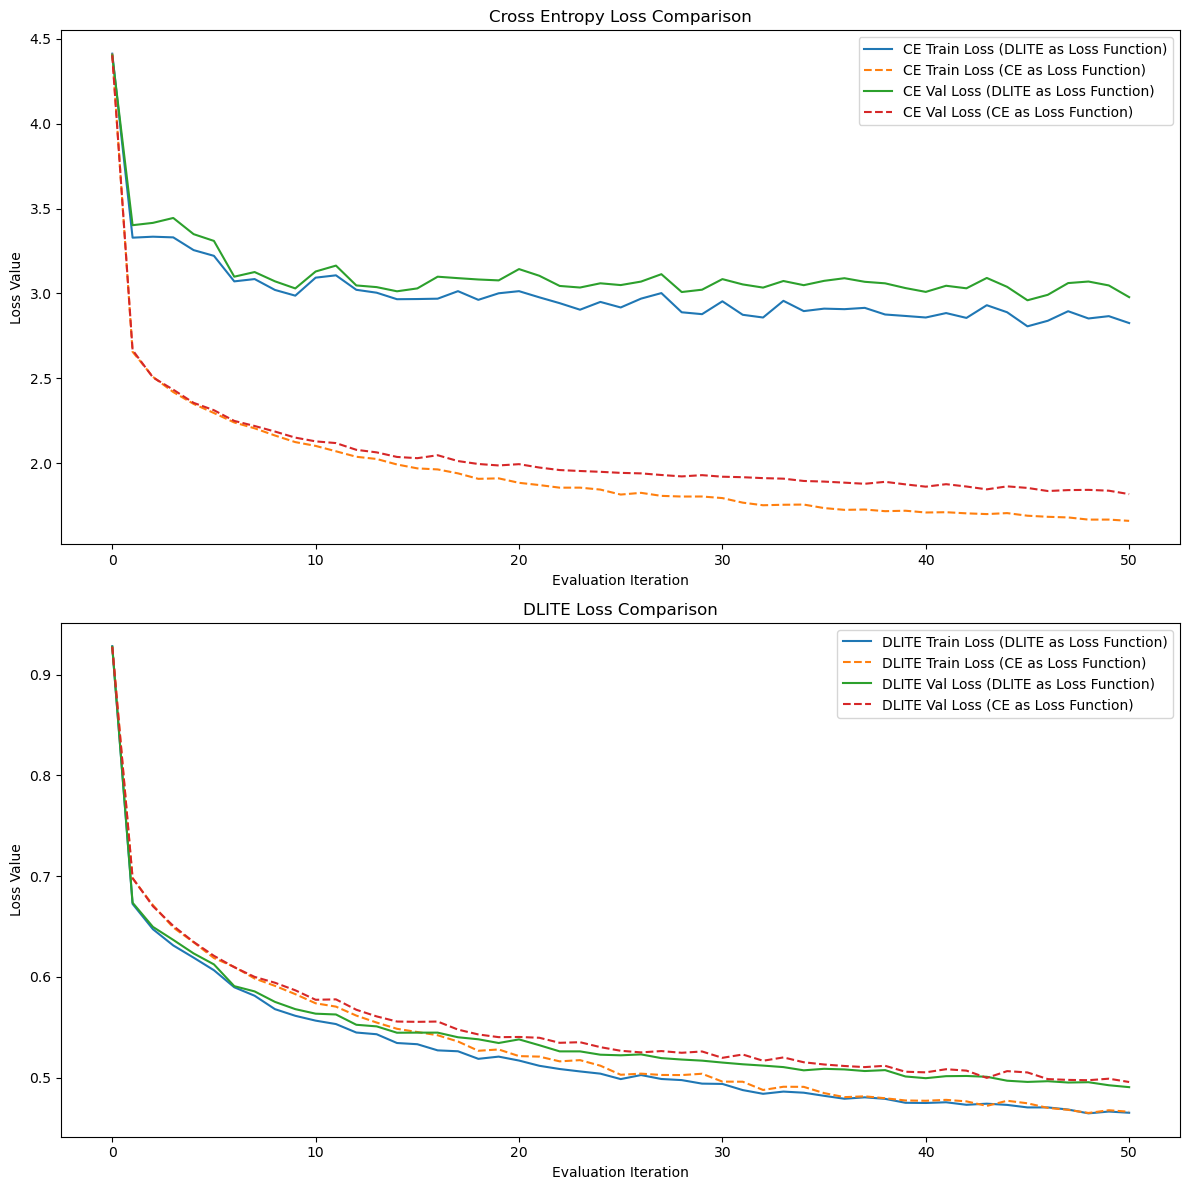

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot CE loss when CE is the loss function vs when DLITE is the loss function
axs[0].plot(ce_train_losses_dlite, label='CE Train Loss (DLITE as Loss Function)', linestyle='-')
axs[0].plot(ce_train_losses_ce, label='CE Train Loss (CE as Loss Function)', linestyle='--')
axs[0].plot(ce_val_losses_dlite, label='CE Val Loss (DLITE as Loss Function)', linestyle='-')
axs[0].plot(ce_val_losses_ce, label='CE Val Loss (CE as Loss Function)', linestyle='--')
axs[0].set_title('Cross Entropy Loss Comparison')
axs[0].set_xlabel('Evaluation Iteration')
axs[0].set_ylabel('Loss Value')
axs[0].legend()

# Plot DLITE loss when CE is the loss function vs when DLITE is the loss function
axs[1].plot(train_losses_dlite, label='DLITE Train Loss (DLITE as Loss Function)', linestyle='-')
axs[1].plot(train_losses_ce, label='DLITE Train Loss (CE as Loss Function)', linestyle='--')
axs[1].plot(val_losses_dlite, label='DLITE Val Loss (DLITE as Loss Function)', linestyle='-')
axs[1].plot(val_losses_ce, label='DLITE Val Loss (CE as Loss Function)', linestyle='--')
axs[1].set_title('DLITE Loss Comparison')
axs[1].set_xlabel('Evaluation Iteration')
axs[1].set_ylabel('Loss Value')
axs[1].legend()

plt.tight_layout()
plt.show()

